# 09 Dataset and DataLoader

In [218]:
import torch 
import torchvision as tv 
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import math 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [280]:
class WineDataset(Dataset):
    def __init__(self):
        xy = np.loadtxt('wine.csv', delimiter=",", dtype=np.float32, skiprows=1)
        sc = StandardScaler()
        x_train, x_test, y_train, y_test = train_test_split(xy[:, 1:], xy[:, 0] - 1, test_size=0.2)
        self.x = torch.from_numpy(sc.fit_transform(x_train))
        self.y = torch.from_numpy(y_train.astype(np.int64))
        self.x_test = torch.from_numpy(x_test)
        self.y_test = torch.from_numpy(y_test.astype(np.int64))
        self.n_samples = x_train.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    

In [281]:
dataset = WineDataset()
dataset[0]

(tensor([-0.1740, -0.6836,  0.5017, -0.5680, -0.3358,  0.3373,  0.3946, -0.8845,
         -0.1909, -0.5032,  0.6587,  1.4392,  0.8622]),
 tensor(0))

In [282]:
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)

In [283]:
dataiter = iter(dataloader)
data = dataiter.next()
data

[tensor([[ 0.7762, -0.6315, -0.0685, -0.1759,  0.4390,  0.9562,  1.2127, -1.2004,
           0.6498,  0.7323,  0.6587,  0.4121,  2.4561],
         [-0.8508, -1.2133, -1.5298, -1.4728,  2.5520, -0.6073, -0.1242, -0.1736,
           2.0396, -0.7237,  0.5244, -0.3685,  0.0175],
         [-0.1740,  0.7667,  0.7156,  0.6988,  0.4390, -1.0144, -1.3714,  1.8012,
          -1.0488,  0.1832, -0.3264, -0.6424, -0.5562],
         [-0.3432, -0.5533, -0.3536,  0.8496, -1.1106, -1.4541, -0.2140,  0.8533,
           0.1008, -0.7653, -0.2816, -0.2179, -0.8176]]),
 tensor([0, 1, 2, 1])]

In [410]:
nepochs = 2000
samples = len(dataset)
n_it = math.ceil(samples/4)
n_it

36

In [447]:
import torch.nn as nn 

class WineModel(nn.Module):
    def __init__(self, input_size):
        super(WineModel, self).__init__()
        self.d1 = nn.Linear(input_size, 32)
        self.d2 = nn.Linear(32, 32)
        self.d3 = nn.Linear(32, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.d1(x))
        x = nn.functional.relu(self.d2(x))
        # return nn.functional.relu(self.d3(x))
        return self.d3(x)

In [493]:
model = WineModel(13)

In [494]:
criteria = nn.CrossEntropyLoss()
lr = 0.00001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [495]:
losses = []
t_loss = []

vloss = []
stop_cr = 0
last_best = 1000

for epoch in range(nepochs):
    for i, (inputs, labels) in enumerate(dataloader):
        y_pred = model(inputs)
        loss = criteria(y_pred, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        t_loss.append(loss.item())
        
            
    losses.append(np.mean(t_loss))
    t_loss = []
            
    vloss += [criteria(model(dataset.x_test), dataset.y_test).item()]
    if vloss[-1] < last_best:
        last_best = vloss[-1]
        stop_cr = 0
    else:
        stop_cr += 1
    
    if stop_cr == 10:
        break
        
    print(f'epoch: {epoch+1}/{nepochs}, loss = {loss.item():.10f}, val loss = {vloss[-1]:.10f}')

epoch: 1/2000, loss = 1.0940611362, val loss = 16.2694950104
epoch: 2/2000, loss = 1.2336566448, val loss = 16.2392272949
epoch: 3/2000, loss = 1.1578824520, val loss = 16.2104530334
epoch: 4/2000, loss = 1.1612272263, val loss = 16.1825561523
epoch: 5/2000, loss = 1.0096404552, val loss = 16.1547966003
epoch: 6/2000, loss = 1.0306637287, val loss = 16.1264152527
epoch: 7/2000, loss = 1.2314867973, val loss = 16.0968799591
epoch: 8/2000, loss = 1.2098596096, val loss = 16.0685939789
epoch: 9/2000, loss = 1.2724972963, val loss = 16.0388317108
epoch: 10/2000, loss = 1.0829541683, val loss = 16.0106830597
epoch: 11/2000, loss = 1.1036411524, val loss = 15.9830760956
epoch: 12/2000, loss = 1.0708961487, val loss = 15.9554796219
epoch: 13/2000, loss = 1.1565721035, val loss = 15.9274187088
epoch: 14/2000, loss = 1.0852992535, val loss = 15.8999433517
epoch: 15/2000, loss = 0.9761976004, val loss = 15.8727331161
epoch: 16/2000, loss = 1.1215239763, val loss = 15.8445262909
epoch: 17/2000, l

In [501]:
nn.functional.softmax(model(dataset.x_test), dim=1).argmax(dim=1).eq(dataset.y_test).sum() / dataset.x_test.shape[0]

tensor(0.2778)

In [487]:
import matplotlib.pyplot as plt

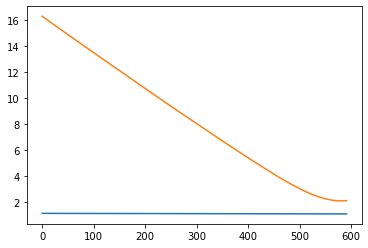

In [502]:
plt.plot(losses)
plt.plot(vloss)
plt.show()